In [ ]:
import sys, os
from glob import glob

sys.path.append('..')

from argparse import ArgumentParser
from easydict import EasyDict
from addict import Dict

from toolz import *
from toolz.curried import *

import numpy as np
import torch
import torchvision
import torch.nn.functional as F

from data.dataLoader import MakeDataLoader

from model.FFTNet import FFTNet
from model.FFTNet import FFTNet_DSNT
from model.UNet import UNet
from model.DeepLab import DeepLab 
from model.NonLocal import NonLocal 
from model.TRANS import TRANS 

from ptflops import get_model_complexity_info

# Get modelSize and FLOPS(G)

In [2]:
def loadModel(model, modelName, encoderName):
    
    inputSize = 256
    
    if model == "FFTNet":        
        learnSize = 21
        codeSize  = 71        
        net       = FFTNet.NETS(encoderName, inputSize, learnSize)

    if model == "FFTDSNTNet":        
        learnSize   = 21
        codeSize    = 71
        cov         = 0.01
        net         = FFTNet_DSNT.NETS(encoderName, inputSize, learnSize, cov = cov)        
        
    if model == "UNet":
        net = UNet.NETS(modelName = modelName)
        
    if model == "DeepLab":
        net = DeepLab.NETS(modelName = modelName, encoderName = "resnet50", outputStride = 8)
        
    if model == "NonLocal":
        net = NonLocal.NETS()        
        
    if model == "TRANS":
        net = TRANS.NETS()        
        
    
    return net

def getModelSpec(model, inputSize = (3,256,256)):
    """
    prints a model's size and GFLOPS
    """
    
    GFlop, params = get_model_complexity_info(model, inputSize,
                                             as_strings=True,
                                             print_per_layer_stat=False,
                                             verbose=False)

    return GFlop, params

In [3]:
instances = \
    [["UNet",       "standard", "ignore"],
     ["UNet",       "plus",     "ignore"],
     ["DeepLab",    "standard", "ignore"],
     ["DeepLab",    "plus",     "ignore"],
     ["FFTDSNTNet", "ignore",   "ResNet"],
     ["FFTDSNTNet", "ignore",   "DResNet26"],
     ["FFTDSNTNet", "ignore",   "DResNet54"],
     ["FFTDSNTNet", "ignore",   "DResNet105"],
     ["NonLocal", "ignore",   "ignore"],
     ["TRANS", "ignore",   "ignore"]]


for instance in instances :
    
    model, modelName, encoderName = instance
    
    net = loadModel(model, modelName, encoderName)
    
    GFlop, params = getModelSpec(net.cuda())
    
    print(f"##############{instance}#######################")
    print('{:<30}  {:<8}'.format('Computational complexity: ', GFlop))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    print("\n")

##############['UNet', 'standard', 'ignore']#######################
Computational complexity:       55.84 GMac
Number of parameters:           31.39 M 


##############['UNet', 'plus', 'ignore']#######################
Computational complexity:       138.16 GMac
Number of parameters:           36.63 M 


##############['DeepLab', 'standard', 'ignore']#######################
Computational complexity:       40.99 GMac
Number of parameters:           39.63 M 


##############['DeepLab', 'plus', 'ignore']#######################
Computational complexity:       43.31 GMac
Number of parameters:           39.76 M 




/home/jacob/.pyenv/versions/3.7.2/envs/omop/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


##############['FFTDSNTNet', 'ignore', 'ResNet']#######################
Computational complexity:       23.54 GMac
Number of parameters:           29.71 M 


##############['FFTDSNTNet', 'ignore', 'DResNet26']#######################
Computational complexity:       83.01 GMac
Number of parameters:           22.16 M 


##############['FFTDSNTNet', 'ignore', 'DResNet54']#######################
Computational complexity:       98.11 GMac
Number of parameters:           36.85 M 


##############['FFTDSNTNet', 'ignore', 'DResNet105']#######################
Computational complexity:       117.59 GMac
Number of parameters:           55.84 M 


##############['NonLocal', 'ignore', 'ignore']#######################
Computational complexity:       1.43 GMac
Number of parameters:           447.96 k


##############['TRANS', 'ignore', 'ignore']#######################
Computational complexity:       32.14 GMac
Number of parameters:           105.32 M




# Comparison of Training and Testing Speed (ms/second) 

In [4]:
import time

from torch.optim import Adam

# overwrite the previous FFTNET_DSNT
from model.FFTNet import _FFTNet_DSNT as FFTNet_DSNT

In [5]:
def EvalTime(insntance, batchSize = 10):
            
    net = loadModel(*insntance).cuda()
    
    optimizer = Adam(net.parameters(), lr=0.00001, weight_decay = 0)    
    
    X = torch.randn(batchSize, 3, 256, 256).cuda()
    y = torch.randn(batchSize, 2, 21).cuda() if "FFT" in instance[0] else torch.randn(batchSize, 256, 256).cuda() > 0 
    
    trainTime = TrainStep(X, y, net, optimizer)
    
    validTime = validStep(X, net)
    
    del net
    
    print(f"{instance[0]}: train time : {trainTime * 10**3 / batchSize }, valid time : {validTime[0] * 10**3 / batchSize}, valid time (no ifft) : {validTime[1] * 10**3 / batchSize}" )
    
def TrainStep (x, y, net, optimizer):
    
    t0 = time_sync()
    
    optimizer.zero_grad()
    
    outputs = net(x)
    
    loss = net.getLoss(outputs, y)
    
    loss.backward()    
    optimizer.step()
    
    t1 = time_sync()
    
    return t1-t0

def validStep (x, net):

    t0 = time_sync()

    outputs = net(x)
    
    t1 = time_sync()
    print(outputs["logit"].shape)
    torch.fft.ifft(outputs["logit"][0, :] + 1j * outputs["logit"][1, :], norm='ortho')
    
    t2 = time_sync()
    
    return  t2-t0, t2-t1

def time_sync():
    # pytorch-accurate time
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    return time.time()

In [7]:
instances = \
    [["UNet",       "plus",     "ignore"],
     ["DeepLab",    "plus",     "ignore"],
     ["TRANS", "ignore",   "ignore"],
     ["FFTDSNTNet", "ignore",   "ResNet"],
     ["FFTDSNTNet", "ignore",   "DResNet54"]
    ]

for instance in instances :    
    EvalTime(instance)

torch.Size([10, 2, 256, 256])
UNet: train time : 45.2221155166626, valid time : 13.590025901794434, valid time (no ifft) : 0.06532669067382812
torch.Size([10, 2, 256, 256])
DeepLab: train time : 15.329837799072266, valid time : 4.40521240234375, valid time (no ifft) : 0.06282329559326172
torch.Size([10, 2, 256, 256])
TRANS: train time : 20.305347442626953, valid time : 6.032919883728027, valid time (no ifft) : 0.07128715515136719
torch.Size([10, 2, 21])
FFTDSNTNet: train time : 6.314969062805176, valid time : 1.6178131103515625, valid time (no ifft) : 0.05733966827392578
torch.Size([10, 2, 21])
FFTDSNTNet: train time : 13.747763633728027, valid time : 4.032707214355469, valid time (no ifft) : 0.0688314437866211


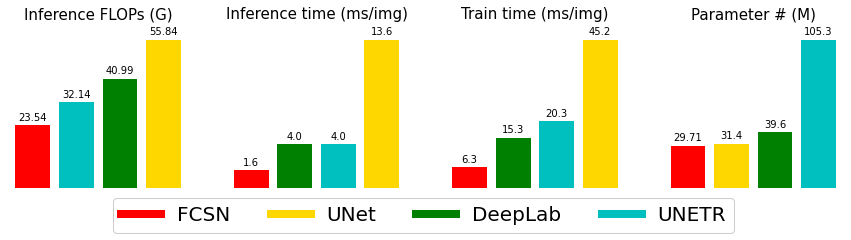

In [1]:
import plotinpy as pnp
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D


modelColours = \
    {"FCSN"    : "red",
     "UNet"    : "gold",
     "DeepLab" : "green",
     "UNERT"   : "c"}

infos = [
        {"title"  : "Inference FLOPs (G)",
          "break" : [],
          "X"     : ["FCSN", "UNet", "DeepLab", "UNERT"],
          "Y"     : [23.54, 55.84, 40.99, 32.14]},
         
         {"title" : "Inference time (ms/img)",
          "break" : [],          
          "X"     : ["FCSN", "UNet", "DeepLab", "UNERT"],
          "Y"     : [1.6, 13.6, 4,4, 6.0]},
         
         {"title" : "Train time (ms/img)",
          "break" : [],
          "X"     : ["FCSN", "UNet", "DeepLab", "UNERT"],
          "Y"     : [6.3, 45.2, 15.3, 20.3]},
         
         {"title" : "Parameter # (M)",
          "break" : [],
          "X"     : ["FCSN", "UNet", "DeepLab", "UNERT"],
          "Y"     : [29.71, 31.4, 39.6, 105.3]},         
         ]

plt.rcParams["figure.figsize"] = (15,3)
for i, info in enumerate(infos):
    
    plt.subplot(1, 4, i+1)
    
    xs, ys = zip(*sorted(zip(info["X"],info["Y"]), key = lambda pair : pair[1]))
    
    pnp.plot_bars_with_breaks(ys,
                              info["break"],
                              color = [ modelColours[x] for x in xs],
                              bar_group_width = 0.8,
                              style = "~",
                              break_args={"hatch": '////'})
                              
    plt.title(info["title"], fontsize=15)
    plt.axis('off') 
    plt.ylim(top=max(ys) * 1.1)
    
custom_lines = [Line2D([0], [0], color="red", lw=8),
                Line2D([0], [0], color="gold", lw=8),
                Line2D([0], [0], color="green", lw=8),
                Line2D([0], [0], color="c", lw=8),]

    
plt.legend(custom_lines, ["FCSN", "UNet","DeepLab","UNETR"],
           ncol = 6,
           fontsize = 20,
           bbox_to_anchor=(0.45,0),
           framealpha=1)        
plt.show()
